In [1]:
import pandas as pd
from pathlib import Path


In [2]:
from pathlib import Path
print(Path.cwd())

/content


In [3]:

from pathlib import Path
import pandas as pd

# Directly specify the absolute file paths under /content
qos = pd.read_csv("/content/network_qos.csv")
usage = pd.read_csv("/content/usage.csv")
revenue = pd.read_csv("/content/revenue.csv")
complaints = pd.read_csv("/content/complaints.csv")

# Merge all datasets by region
df = (
    qos.merge(usage, on="region", how="left")
       .merge(revenue, on="region", how="left")
       .merge(complaints, on="region", how="left")
)

# Handle missing values gracefully
df.fillna({
    "signal_strength": df["signal_strength"].mean(),
    "latency_ms": df["latency_ms"].mean(),
    "throughput_mbps": df["throughput_mbps"].mean(),
    "complaints": 0
}, inplace=True)

# Save clean merged dataset
Path("/content/outputs").mkdir(exist_ok=True)
df.to_csv("/content/outputs/network_master.csv", index=False)

print("✅ Clean dataset saved at: /content/outputs/network_master.csv")

# Preview the first few rows
df.head()

✅ Clean dataset saved at: /content/outputs/network_master.csv


,region,signal_strength,latency_ms,throughput_mbps,outages,data_gb,call_minutes,dropped_calls,ARPU,customer_count,complaints,month
0,Delhi,-70,25,35,2,250,300000,100,320,56000,110,Aug
1,Mumbai,-65,20,42,1,270,290000,90,400,64000,95,Aug
2,Chennai,-75,28,32,3,220,270000,120,280,49000,140,Aug
3,Kolkata,-72,30,30,2,180,260000,130,250,45000,150,Aug
4,Hyderabad,-68,22,40,1,260,275000,110,380,51000,100,Aug


In [4]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
df = pd.read_csv("outputs/network_master.csv")

print(df.describe())


       signal_strength  latency_ms  throughput_mbps  outages     data_gb  \
count         5.000000    5.000000         5.000000  5.00000    5.000000   
mean        -70.000000   25.000000        35.800000  1.80000  236.000000   
std           3.807887    4.123106         5.118594  0.83666   36.469165   
min         -75.000000   20.000000        30.000000  1.00000  180.000000   
25%         -72.000000   22.000000        32.000000  1.00000  220.000000   
50%         -70.000000   25.000000        35.000000  2.00000  250.000000   
75%         -68.000000   28.000000        40.000000  2.00000  260.000000   
max         -65.000000   30.000000        42.000000  3.00000  270.000000   

        call_minutes  dropped_calls        ARPU  customer_count  complaints  
count       5.000000       5.000000    5.000000        5.000000    5.000000  
mean   279000.000000     110.000000  326.000000    53000.000000  119.000000  
std     15968.719423      15.811388   63.874878     7314.369419   24.596748  
min

Correlation Analysis

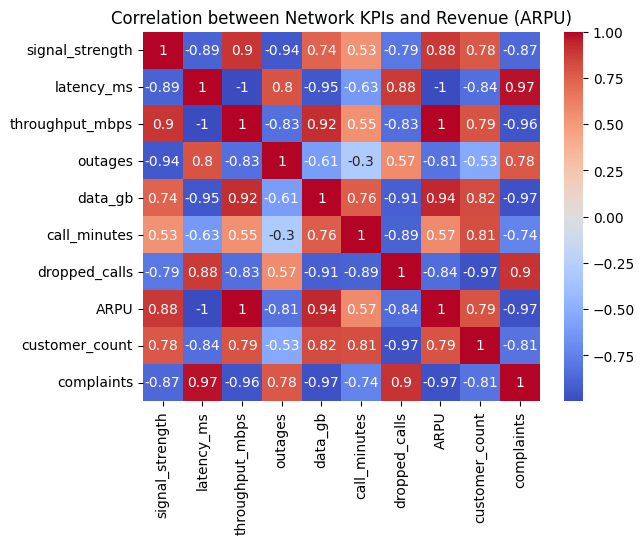

In [6]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation between Network KPIs and Revenue (ARPU)")
plt.show()



ARPU vs Latency

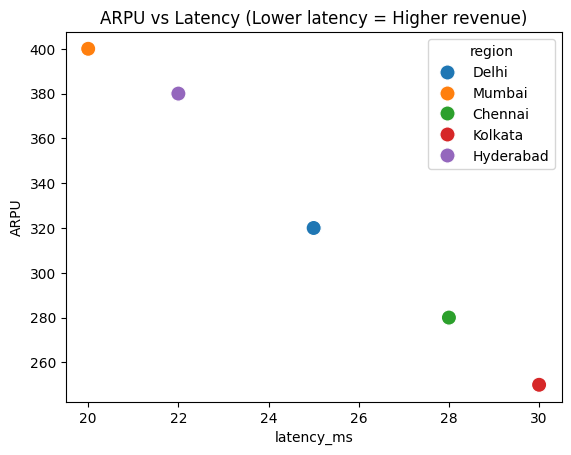

In [7]:
sns.scatterplot(x="latency_ms", y="ARPU", data=df, hue="region", s=120)
plt.title("ARPU vs Latency (Lower latency = Higher revenue)")
plt.show()


Complaints per Region

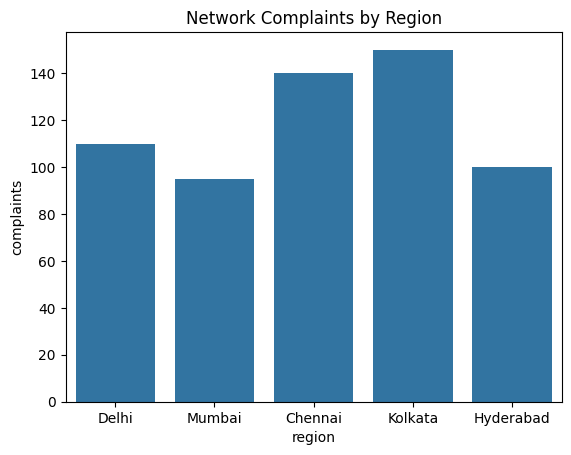

In [8]:
sns.barplot(x="region", y="complaints", data=df)
plt.title("Network Complaints by Region")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [10]:
df = pd.read_csv("outputs/network_master.csv")

X = df[["latency_ms", "throughput_mbps", "complaints", "data_gb", "outages"]]
y = df["ARPU"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression R²: -25.699353776885893
MAE: 51.41069589970323


Decision Tree Regressor

In [12]:
dt = DecisionTreeRegressor(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
print("Decision Tree R²:", r2_score(y_test, y_pred_dt))
print("MAE:", mean_absolute_error(y_test, y_pred_dt))


Decision Tree R²: -49.0
MAE: 70.0


Compare Models

In [13]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree"],
    "R2_Score": [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_dt)],
    "MAE": [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_dt)]
})
print(results)


               Model   R2_Score        MAE
0  Linear Regression -25.699354  51.410696
1      Decision Tree -49.000000  70.000000


Predict “At Risk” Regions (Classification)

In [14]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create binary label: 1 = low ARPU, 0 = normal/high
df["low_revenue_flag"] = np.where(df["ARPU"] < df["ARPU"].median(), 1, 0)

X = df[["latency_ms","throughput_mbps","complaints","outages","data_gb"]]
y = df["low_revenue_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
[[2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
